In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/demres

/Users/zurfarosa/demres


In [52]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import pylab as pl
from datetime import date, timedelta

import demres
from demres.common.constants import entry_type
from demres.common import codelists
from demres.common.helper_functions import *

In [4]:
%matplotlib inline

In [5]:
pt_features = pd.read_csv('data/pt_data/processed_data/pt_features_demins.csv',delimiter=',',parse_dates=['index_date','data_end','data_start'],infer_datetime_format=True)

In [6]:
# pt_features = pt_features.drop(['matchid','patid','data_start','data_end','final dementia medcode','index_date'],axis=1)

In [7]:
pt_features.pracid = pt_features.pracid.astype(str)

In [8]:
pt_features.sample(3)

,patid,gender,yob,pracid,index_date,isCase,final dementia medcode,data_start,data_end,matchid,insom_count_window0,insom_count_window1
1632,13608189,1,1928,189,2010-02-23,False,NaN,1999-11-24,2012-08-10,28367.0,0,0
5975,914277,1,1929,277,2010-10-19,False,NaN,1998-10-31,2013-05-17,42366.0,0,0
11285,8949343,1,1931,343,2009-10-13,False,NaN,1995-09-15,2012-08-16,51698.0,0,0


In [9]:
pt_features = pt_features.loc[:,['isCase','gender','yob','insom_count_window0','insom_count_window1']]

In [10]:
pt_features.head(3)

,isCase,gender,yob,insom_count_window0,insom_count_window1
0,True,2,1925,0,0
1,True,2,1927,0,0
2,True,2,1919,1,1


In [11]:
pt_features.describe()

,gender,yob,insom_count_window0,insom_count_window1
count,12736.000000,12736.000000,12736.000000,12736.000000
mean,1.638348,1927.139447,0.223540,0.202732
std,0.480498,6.434865,0.801774,0.917249
min,1.000000,1906.000000,0.000000,0.000000
25%,1.000000,1922.000000,0.000000,0.000000
50%,2.000000,1927.000000,0.000000,0.000000
75%,2.000000,1931.000000,0.000000,0.000000
max,2.000000,1946.000000,28.000000,36.000000


In [12]:
pd.crosstab(pt_features['isCase'],pt_features['insom_count_window1'])

insom_count_window1,0,1,2,3,4,5,6,7,8,11,14,17,22,29,30,34,36
isCase,,,,,,,,,,,,,,,,,
False,5740,398,117,57,30,15,6,0,1,1,0,1,0,1,1,0,0
True,5561,520,152,61,37,19,7,4,2,1,1,0,1,0,0,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a99dba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10a6ae7f0>]], dtype=object)

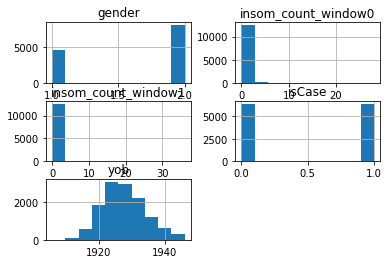

In [13]:
pt_features.hist()

In [44]:
pt_features

,isCase,gender,yob,insom_count_window0,insom_count_window1,intercept
0,True,2,1925,0,0,1
1,True,2,1927,0,0,1
2,True,2,1919,1,1,1
3,True,1,1939,0,0,1
4,True,1,1933,0,1,1
5,True,2,1925,0,0,1
6,True,1,1921,0,0,1
7,True,1,1931,0,0,1
8,True,1,1931,0,0,1
9,True,1,1919,0,0,1


In [64]:
train_cols = pt_features.columns[[3,5]]

In [65]:
train_cols

Index(['insom_count_window0', 'intercept'], dtype='object')

In [66]:
pt_features[train_cols] = add_constant(pt_features[train_cols])

In [67]:
logit = sm.Logit(pt_features['isCase'], pt_features[train_cols])

In [68]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.693002
         Iterations 4


In [69]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 isCase   No. Observations:                12736
Model:                          Logit   Df Residuals:                    12734
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2017   Pseudo R-squ.:               0.0002096
Time:                        18:53:44   Log-Likelihood:                -8826.1
converged:                       True   LL-Null:                       -8827.9
                                        LLR p-value:                   0.05438
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
insom_count_window0     0.0433      0.023      1.893      0.058      -0.002       0.088
intercept              -0.0096      0.018     -0.523      0.601      -0.046       0.026
=======================================================================================
"""

In [70]:
np.exp(result.params)

insom_count_window0    1.044244
intercept              0.990403
dtype: float64

In [71]:
get_windows()

[{'end_latency': datetime.timedelta(3650),
  'start_latency': datetime.timedelta(1825)},
 {'end_latency': datetime.timedelta(1825),
  'start_latency': datetime.timedelta(0)}]